In [1]:
from dotenv import load_dotenv
import os
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import MessagesState,StateGraph,START, END
from typing_extensions import TypedDict
from langchain_groq import ChatGroq
from typing import Literal
from typing import Annotated
from langchain_core.tools import tool
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langgraph.prebuilt import create_react_agent
from langchain_fmp_data.tools import ResponseFormat
from langchain_tavily import TavilySearch

from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_fmp_data import FMPDataTool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["FMP_API_KEY"] = os.getenv("FMP_API_KEY")
os.environ["SERP_API_KEY"] = os.getenv("SERP_API_KEY")

In [4]:
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
print(llm.invoke("Hi?"))

content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 5, 'total_tokens': 21, 'completion_time': 0.092011767, 'prompt_time': 0.000118739, 'queue_time': 0.052603701, 'total_time': 0.092130506}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None} id='run--a90c4361-8b5d-4cf5-a37c-191c6cfa6c28-0' usage_metadata={'input_tokens': 5, 'output_tokens': 16, 'total_tokens': 21}


### Message Satate class

In [6]:
class State(MessagesState):
    next:str

## Supervisor Node

In [7]:
class SupervisorRouter(TypedDict):
    next: Literal['research_supervisor', 'reports_supervisor', '__end__']

In [8]:
supervisor_agent_prompt = f"""
You are a Supervisor Agent responsible for routing user requests to the appropriate sub-agent based on the intent and context of the conversation. Your role is to analyze the user's messages and the conversation state to determine the next step in the workflow. You can route to one of the following commands:

- **research_supervisor**: Routes to agents handling medical/pharma research or financial research. Select this if the user is asking for information, analysis, or insights related to medical/pharma topics (e.g., drug discovery, clinical trials, healthcare data) or financial topics (e.g., market analysis, stock trends, investment strategies).
- **reports_supervisor**: Routes to agents responsible for generating summaries, reports, or formatted outputs (e.g., PDF or DOCX documents) based on research or conversation results. Select this if the user requests a summary, document, or formatted output, or if research has been completed and a summary needs to be generated.
- **__end__**: Terminates the workflow if the user's request has been fully addressed, no further action is needed, or the intent is unclear and cannot be routed.

### Input:
The state object, which inherits from MessagesState, contains:
- A 'next' field (str) indicating the current stage of the workflow or the next agent to route to.
- Conversation history (messages) containing user requests and agent responses.

### Instructions:
1. Analyze the 'next' field and the conversation history in the state to identify the user's intent and workflow stage.
2. If the 'next' field indicates research is needed (e.g., 'next' is empty, null, or set to 'research'), or the user's latest message requests medical/pharma or financial research, route to 'research_supervisor'.
3. If the 'next' field indicates research is complete (e.g., 'next' is set to 'research_complete' or similar), or the user requests a summary, report, or formatted output (e.g., PDF or DOCX), route to 'reports_supervisor'.
4. If research has been completed (e.g., messages contain research results and 'next' is 'research_complete'), always route to 'reports_supervisor' to generate and save a summary in PDF or DOCX format, even if not explicitly requested by the user.
5. If the 'next' field or intent is ambiguous, unclear, or the workflow is complete (e.g., 'next' is 'done' or messages indicate no further action), route to '__end__'.
6. Provide a single command as output: 'research_supervisor', 'reports_supervisor', or '__end__'.
7. Do not provide explanations or additional text beyond the command name.
"""

In [9]:
def supervisor_agent(state:State)->Command[Literal['research_supervisor', 'reports_supervisor', '__end__']]:
    """Supervisor Agent function to route user requests based on intent and context."""
    # Print the state for debugging purposes
    print(f"---------------- Supervisor Agent invoked with state: {state} ----------------")

    # Prepare the messages for the LLM, including the system prompt
    messages = [{"role": "system", "content": supervisor_agent_prompt},] + state["messages"]

    llm_with_supervisor_router = llm.with_structured_output(SupervisorRouter)

    response=llm_with_supervisor_router.invoke(messages)

    goto = response["next"]
    print(f"response: {response} \ngoto: {goto}")

    if goto == "__end__":
        goto=END

    print(f"command : {Command(goto=goto, update={'next': goto})}")
    return Command(goto=goto, update={"next": goto})

## 1. Reaserach Team

#### 1.1 Reaserach Router

In [10]:
class ResearchRouter(TypedDict):
    next: Literal['medical_agent', 'finance_agent', 'supervisor']

In [11]:
research_team_supervisor_prompt = f""" 
You are a Research Team Supervisor Agent responsible for routing research tasks to the appropriate agent based on their domain. Your task is to analyze the research request in the provided state and determine which agent should handle it. The possible agents are:

medical_agent: For research tasks related to medical, pharmaceutical, healthcare, or biological topics.
finance_agent: For research tasks related to finance, economics, banking, investments, or financial markets.
supervisor: For all other research tasks that do not clearly fall into the medical or finance domains, or when the task requires higher-level oversight.

Input: The state object contains the research request, which includes a description of the task or query to be researched.
Instructions:

Analyze the research request in the state to identify its domain.
If the request involves medical, pharmaceutical, healthcare, or biological topics, Route to the command "medical_agent".
If the request involves finance, economics, banking, investments, or financial markets, Route to the command "finance_agent".
For any other topic or if the request is ambiguous and requires higher-level decision-making, Route to the command "supervisor".
Route only the command name as a string: "medical_agent", "finance_agent", or "supervisor".
Do not provide explanations or additional text beyond the command name.

"""


#### 1.2 Reaserach team supervisor:

In [12]:
def reresearch_team_supervisor_agent(state:State)->Command[Literal['medical_agent', 'finance_agent', 'supervisor']]:
    # Print the state for debugging purposes
    print(f"---------------- Reasreach team Agent invoked with state: {state} ----------------")

    # Prepare the messages for the LLM, including the system prompt
    messages = [{"role": "system", "content": research_team_supervisor_prompt},] + state["messages"]

    llm_with_research_router = llm.with_structured_output(ResearchRouter)

    response=llm_with_research_router.invoke(messages)

    goto = response["next"]
    print(f"response: {response} \ngoto: {goto}")

    # if goto == "FINISH":
    #     goto=END

    print(f"command : {Command(goto=goto, update={'next': goto})}")
    return Command(goto=goto, update={"next": goto})

##### 1.2.1 Medical Pharma Agent:

In [13]:
medical_tools = [PubmedQueryRun(), TavilySearch()]
medical_research_agent_prompt = f"""
You are a Medical Research Agent responsible for conducting research on medical, pharmaceutical, healthcare, or biological topics based on the user's request. Your task is to analyze the request, provide relevant information, insights, or data, and route the workflow appropriately.

### Input:
The state object, which inherits from MessagesState, contains:
- A 'next' field (str) indicating the current stage of the workflow or the next agent to route to.
- Conversation history (messages) containing user requests and prior responses.

### Instructions:
1. Analyze the user's latest request and conversation history in the state to identify the medical research topic (e.g., disease information, treatment options, pharmaceutical data, healthcare trends, or biological mechanisms).
2. If the 'next' field is empty, null, or indicates a new research task (e.g., 'research'), conduct the medical research using available data in the state or your knowledge base. Store the results in the state and set 'next' to 'research_complete'.
3. If up-to-date information or news is required and not available in your knowledge base, route to the command 'tavily_search' to fetch the latest data using the TavilySearch tool.
4. If research is complete (e.g., 'next' is 'research_complete' or the state contains sufficient research results), route to the command 'reports_supervisor' to generate a summary in PDF or DOCX format.
5. If the request is ambiguous, incomplete, or requires higher-level expertise (e.g., proprietary medical data or clinical trial access), route to the command 'research_supervisor' with appropriate feedback in the state.
6. Provide a single command as output: 'tavily_search', 'reports_supervisor', or 'research_supervisor'.
7. Do not provide explanations or additional text beyond the command name.
"""

In [14]:
def medical_agent(state:State)->Command[Literal['research_supervisor']]:
    print(f"---------------- Medical Agent invoked with state: {state} ----------------")
    medical_agent=create_react_agent(model=llm, tools=medical_tools, prompt=medical_research_agent_prompt)
    result=medical_agent.invoke(state)

    return Command(
        goto="research_supervisor",
        update={"messages": [
            HumanMessage(content=result["messages"][-1].content, name="medical_agent")
        ]}
    )



##### 1.2.2 Financial Agent:

In [15]:
financial_research_agent_prompt = f"""
You are a Financial Research Agent responsible for conducting research on financial topics based on the user's request. Your task is to analyze the request, provide relevant information, insights, or data related to finance, economics, banking, investments, or financial markets, and route the workflow appropriately.

### Input:
The state object, which inherits from MessagesState, contains:
- A 'next' field (str) indicating the current stage of the workflow or the next agent to route to.
- Conversation history (messages) containing user requests and prior responses.

### Instructions:
1. Analyze the user's latest request and conversation history in the state to identify the financial research topic (e.g., market analysis, stock trends, investment strategies, economic data).
2. If the 'next' field is empty, null, or indicates a new research task (e.g., 'research'), conduct the financial research using available data in the state or your knowledge base. Store the results in the state and set 'next' to 'research_complete'.
3. If up-to-date information or news is required and not available in your knowledge base, route to the command 'tavily_search' to fetch the latest news or data.
4. If research is complete (e.g., 'next' is 'research_complete' or the state contains sufficient research results), route to the command 'reports_supervisor' to generate a summary in PDF or DOCX format.
5. If the request is ambiguous, incomplete, or requires higher-level oversight, route to the command 'research_supervisor' with appropriate feedback in the state.
6. Provide a single command as output: 'tavily_search', 'reports_supervisor', or 'research_supervisor'.
7. Do not provide explanations or additional text beyond the command name.
"""

finance_tools = [YahooFinanceNewsTool(),FMPDataTool(), TavilySearch()]


2025-07-10 16:52:14,235 - fmp_data.fmp_data.base - INFO - Initializing API client
2025-07-10 16:52:14,302 - fmp_data.fmp_data.lc.vector_store - WARNING - Missing endpoints in store: {'get_most_active', 'get_etf_holder', 'get_available_indexes', 'get_sector_performance', 'get_commodity_quote', 'get_wma', 'get_market_risk_premium', 'get_house_disclosure', 'get_sma', 'get_ema', 'get_company_notes', 'get_levered_dcf', 'get_etf_holdings', 'get_crowdfunding_rss', 'get_adx', 'get_forex_news', 'get_price_target_consensus', 'get_upgrades_downgrades', 'get_historical_market_cap', 'get_product_revenue_segmentation', 'get_analyst_recommendations', 'get_crypto_list', 'get_market_cap', 'get_senate_trading', 'search', 'get_crypto_quote', 'get_form_13f_dates', 'get_fmp_articles', 'get_crypto_quotes', 'get_etf_exposure', 'get_etf_holding_dates', 'get_commodities_list', 'get_crowdfunding_by_cik', 'get_earnings_confirmed', 'get_balance_sheet', 'get_mutual_fund_dates', 'get_financial_reports_dates', 'get_

In [16]:
def finance_agent(state:State)->Command[Literal['research_supervisor']]:
    finance_agent = create_react_agent(model=llm, tools=finance_tools, prompt=financial_research_agent_prompt)
    result = finance_agent.invoke(state)

    return Command(
        goto="research_supervisor",
        update={"messages": [
            HumanMessage(content=result["messages"][-1].content, name="finance_agent")
        ]}
    )

## 2. Reports Team

#### 2.1 Reports Router

In [17]:
class ReportsRouter(TypedDict):
    next: Literal['summary_agent', 'document_agent', 'supervisor']

In [18]:
report_team_supervisor_prompt = f"""
You are a Reports Team Supervisor Agent responsible for managing the workflow of generating and saving research summaries. Your task is to route the workflow based on the current state of the research process. The possible agents are:

summary_agent: For generating a summary of all prior research data contained in the state.
document_agent: For saving the generated summary in PDF or DOCX format.
supervisor: For returning control to the higher-level supervisor after the summary is saved or if further oversight is needed.

Input: The state object contains the research data, including prior research, the current status of the summary, and any instructions for saving the output.
Instructions:

Analyze the state to determine the current stage of the workflow.
If no summary has been generated, route to the command "summary_agent" to create a summary of all prior research.
If a summary has been generated but not saved, route to the command "document_agent" to save the summary in PDF or DOCX format, as specified in the state or context.
If the summary has been generated and saved, route to the command "supervisor" to return control to the higher-level supervisor with the updated state, including the saved document's metadata (e.g., file path or format).
If the state is ambiguous or contains errors (e.g., missing research data or invalid format), route to the command "supervisor" with appropriate feedback in the state.
Route only the command name as a string: "summary_agent", "document_agent", or "supervisor".
Do not provide explanations or additional text beyond the command name.
"""

#### 2.2 Reports team supervisor:

In [ ]:
def reports_team_supervisor_agent(state:State)->Command[Literal['summary_agent', 'document_agent','supervisor']]:
    print(f"---------------- Report team Agent invoked with state: {state} ----------------")

    # Prepare the messages for the LLM, including the system prompt
    messages = [{"role": "system", "content": report_team_supervisor_prompt},] + state["messages"]

    llm_with_research_router = llm.with_structured_output(ReportsRouter)

    response=llm_with_research_router.invoke(messages)

    goto = response["next"]
    print(f"response: {response} \ngoto: {goto}")

    # if goto == "FINISH":
    #     goto=END

    print(f"command : {Command(goto=goto, update={'next': goto})}")
    return Command(goto=goto, update={"next": goto})

##### 2.2.1 Summry of result Agent:

In [26]:
medical_sumary_agent_prompt = f"""
You are a Summary Agent responsible for generating a concise summary based on research data provided from a research agent.

### Instructions:
1. Analyze the research data and the original question to identify key findings.
2. Summarize the findings in a clear, concise, and structured format (e.g., bullet points or short paragraphs).
3. If the research data is insufficient or unclear, use the TavilySearch tool to fetch additional relevant information.
4. Ensure the summary is accurate, relevant to the question's domain, and avoids unnecessary details.
5. If the request requires advanced expertise or proprietary data, include the command 'research_supervisor' in the response.
"""

In [20]:
def summary_agent(state:State)->Command[Literal['reports_supervisor']]:
    pass

##### 2.2.2 Document Agent:

In [21]:
def document_agent(state:State)->Command[Literal['reports_supervisor']]:
    pass

### Graph workflow

In [22]:
graph=StateGraph(State)
graph.add_node("supervisor", supervisor_agent)

graph.add_node("research_supervisor", reresearch_team_supervisor_agent)
graph.add_node("medical_agent", medical_agent)
graph.add_node("finance_agent", finance_agent)

graph.add_node("reports_supervisor",reports_team_supervisor_agent)
graph.add_node("summary_agent", summary_agent)
graph.add_node("document_agent", document_agent)    

graph.add_edge(START,"supervisor")

app=graph.compile()

In [23]:

from IPython.display import display,Image

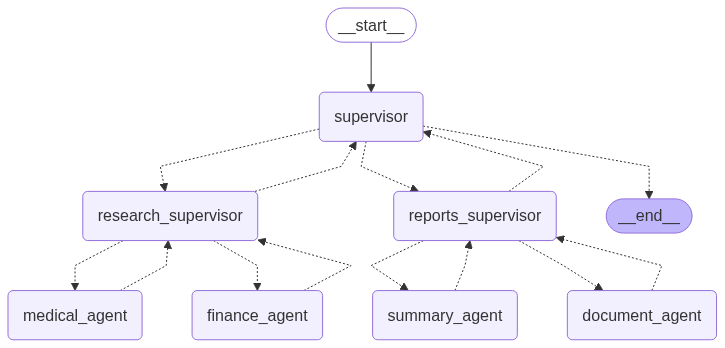

In [24]:
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
for s in app.stream({"messages":[("user","I need to research the latest trends in AI and its applications in healthcare.")]}, subgraphs=True):
    print(s)

---------------- Supervisor Agent invoked with state: {'messages': [HumanMessage(content='I need to research the latest trends in AI and its applications in healthcare.', additional_kwargs={}, response_metadata={}, id='d6a061f0-abc6-44b3-bb69-7bed5eea1c4e')]} ----------------
response: {'next': 'research_supervisor'} 
goto: research_supervisor
command : Command(update={'next': 'research_supervisor'}, goto='research_supervisor')
((), {'supervisor': {'next': 'research_supervisor'}})
---------------- Reasreach team Agent invoked with state: {'messages': [HumanMessage(content='I need to research the latest trends in AI and its applications in healthcare.', additional_kwargs={}, response_metadata={}, id='d6a061f0-abc6-44b3-bb69-7bed5eea1c4e')], 'next': 'research_supervisor'} ----------------
response: {'next': 'medical_agent'} 
goto: medical_agent
command : Command(update={'next': 'medical_agent'}, goto='medical_agent')
((), {'research_supervisor': {'next': 'medical_agent'}})
--------------

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '\n\n<tool_call>{"name": "reports_supervisor", "arguments": {}}</tool_call>'}}